In [3]:
from itertools import combinations

import pandas as pd
import xgboost
import numpy as np

from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import validation_curve
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import RobustScaler

import matplotlib.style
matplotlib.style.use("ggplot")
%matplotlib notebook
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
target = train.pop('TARGET')
train = train.drop(['ID'], axis=1)
Ids = test.pop("ID")

to_drop = []

for col in train.columns:
    # drop constant columns    
    if len(set(train[col])) == 1 or len(set(test[col])) == 1:
        to_drop.append(col)
        
        
# drop columns that are the same as other columns
for col1, col2 in combinations(train.columns, 2):
    condition_1 = all(train[col1] == train[col2])
    condition_2 = all(test[col1] == test[col2])
    
    if condition_1 or condition_2:
        to_drop.append(col2)

to_drop = list(set(to_drop))

train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
    
# add the number of zeros in a row as another feature 
for set_ in [train, test]:
    count0 = set_.apply(lambda x: sum(x == 0), axis=1)
    set_['count0'] = count0

In [5]:
# scale data
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [6]:
# split into 80/20, stratify the train and test sets.
X, x, Y, y = train_test_split(train, target, test_size=0.2, stratify=target)

In [20]:
xgb = xgboost.XGBClassifier(nthread=-1,
                            learning_rate=0.001,
                            subsample=0.9,
                            n_estimators=500,
                            colsample_bytree=0.8,
                            colsample_bylevel=0.8,
                            reg_lambda=10,
                            missing=0,
                        )
xgb.fit(X, Y, eval_metric='auc')

XGBClassifier(base_score=0.5, colsample_bylevel=0.8, colsample_bytree=0.8,
       gamma=0, learning_rate=0.001, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=0, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=10,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [21]:
fpr, tpr, _ = roc_curve(y, xgb.predict_proba(x)[:,1])

<IPython.core.display.Javascript object>


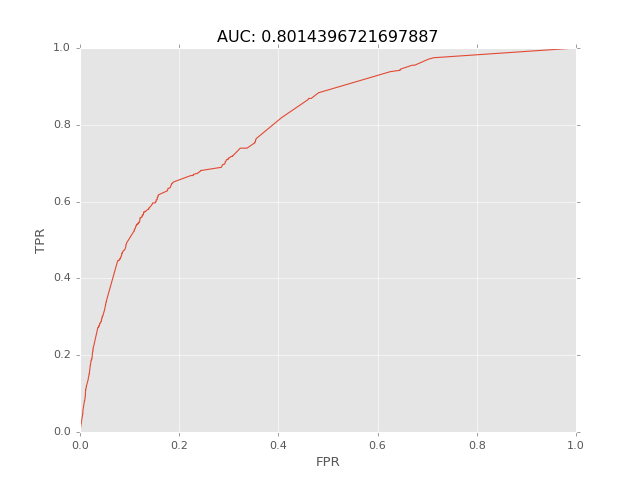

In [22]:
plt.figure()
plt.plot(fpr, tpr)
plt.title("AUC: {}".format(auc(fpr, tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")

In [23]:
# print the confusion matrix, off diagonals should be small
print(confusion_matrix(y, xgb.predict(x)))

[[14602     0]
 [  602     0]]


In [ ]:
submission = pd.DataFrame({"ID": Ids, "TARGET": xgb.predict_proba(test)[:,1]})

In [24]:
print(submission)

NameError: name 'submission' is not defined

In [25]:
submission.to_csv('submission.csv', index=False)

NameError: name 'submission' is not defined

In [ ]:
xgb.get_params()